# Process Rasters
This file is used to process Sentinel-2 scenes so they can be annotated with a vegetation line. The steps for this are:
<ol>
<li>Find the UTM co-ordinates for the AOI of different coastline locations</li>
<li>Use the co-ordiantes to crop sentinel-2 scenes to the AOI and save 10m spectral bands as a TIF file</li>
<li>Each TIF file is loaded into QGIS and annotated with the help of ariel photography. The annotations are saved as shape files. </li>
<li>All shape files are combined into one file</li>
</ol>
The final shape file and AOI TIF files are then sense checked. These will be processed further into the machine learning training data. 

In [116]:
import os
import glob
import numpy as np
import pandas as pd

import rasterio
import geopandas as gpd

import matplotlib.pyplot as plt
import cv2

# reimport 
import utils 
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/utils.py'>

## Step 1: Find geolocations for AOI
For each location, we: 
<ol>
<li> Load an example Sentinel-2 scene. 
<li> Use this to find appropriate pixel coordinates. They should crop the scene so we capture the entire beach with a buffer area around it.  
<li> We then covert these to UTM coordinates so they can be used to crop all scenes from the location. 
</ol>

In [117]:
# Dictionary to store UTM coordinates for AOI
geolocations = {}

### Location: Bull Island, Co. Dublin, Ireland

In [118]:
# Load example scene
file_name = "S2A_MSIL2A_20240623T114351_N0510_R123_T29UPV_20240623T164349"
safe_folder = f"location_examples/{file_name}.SAFE"
safe_directory = os.path.join("../data/raw/", safe_folder)

stacked_bands, meta_data  = utils.stack_10m_bands(safe_directory)
print(stacked_bands.shape)
print(meta_data.profile)

(4, 10980, 10980)
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 29N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32629"]]'), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 6000000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


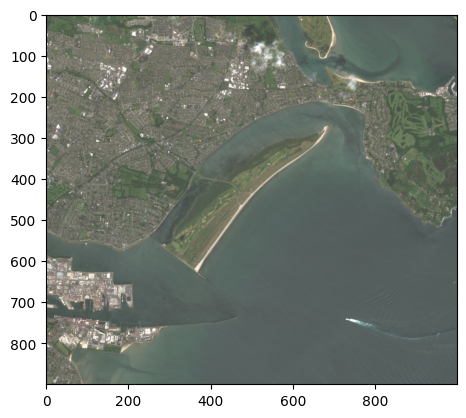

In [119]:
# Find appropriate pixel coordinates 
rgb = utils.get_rgb(stacked_bands,r=2,contrast=0.4)

x1 = 8700-200
y1 = 8050-200
x2 = 9300+200
y2 = 8550+200

crop_rgb = rgb[y1:y2,x1:x2]
plt.imshow(crop_rgb)

In [120]:
# Covert pixel coordinates to UTM coordinates
left, top = meta_data.xy(y1,x1)
right, bottom = meta_data.xy(y2,x2)

# Save geolocations
geolocations["bull_island"] = {
    "left": left,
    "top": top,
    "right": right,
    "bottom": bottom
}

print(geolocations["bull_island"])
print(meta_data.index(left, top))
print(meta_data.index(right, bottom))

{'left': 685005.0, 'top': 5921495.0, 'right': 695005.0, 'bottom': 5912495.0}
(7850, 8500)
(8750, 9500)


### Location: Portmarnock, Co. Dublin, Ireland

In [121]:
file_name = "S2A_MSIL2A_20240623T114351_N0510_R123_T29UPV_20240623T164349"
safe_folder = f"location_examples/{file_name}.SAFE"
safe_directory = os.path.join("../data/raw/", safe_folder)

stacked_bands, meta_data  = utils.stack_10m_bands(safe_directory)
print(stacked_bands.shape)
print(meta_data.profile)

(4, 10980, 10980)
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 29N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32629"]]'), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 6000000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


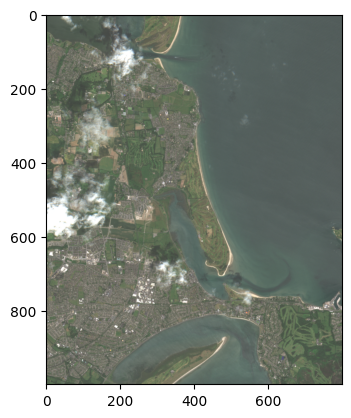

In [122]:
rgb = utils.get_rgb(stacked_bands,r=2,contrast=0.4)

x1 = 8900-200
y1 = 7450-200
x2 = 9300+200
y2 = 8050+200

crop_rgb = rgb[y1:y2,x1:x2]
plt.imshow(crop_rgb)

In [123]:
# Get geolocations for AOI
left, top = meta_data.xy(y1,x1)
right, bottom = meta_data.xy(y2,x2)

# Save geolocations
geolocations["portmarnock"] = {
    "left": left,
    "top": top,
    "right": right,
    "bottom": bottom
}

print(geolocations["portmarnock"])
print(meta_data.index(left, top))
print(meta_data.index(right, bottom))

{'left': 687005.0, 'top': 5927495.0, 'right': 695005.0, 'bottom': 5917495.0}
(7250, 8700)
(8250, 9500)


### Location: Portrane, Co. Dublin, Ireland

In [124]:
file_name = "S2A_MSIL2A_20240623T114351_N0510_R123_T29UPV_20240623T164349"
safe_folder = f"location_examples/{file_name}.SAFE"
safe_directory = os.path.join("../data/raw/", safe_folder)

stacked_bands, meta_data  = utils.stack_10m_bands(safe_directory)
print(stacked_bands.shape)
print(meta_data.profile)

(4, 10980, 10980)
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 29N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32629"]]'), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 6000000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


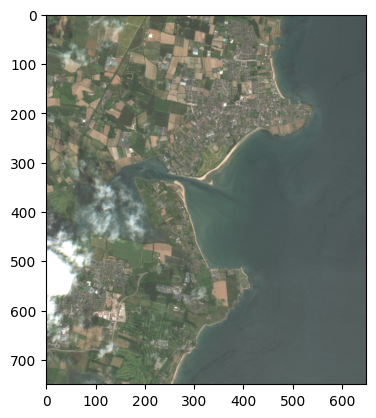

In [125]:
rgb = utils.get_rgb(stacked_bands,r=2,contrast=0.4)

x1 = 9050-200
y1 = 6580-200
x2 = 9300+200
y2 = 6930+200

crop_rgb = rgb[y1:y2,x1:x2]
plt.imshow(crop_rgb )

In [126]:
# Get geolocations for AOI
left, top = meta_data.xy(y1,x1)
right, bottom = meta_data.xy(y2,x2)

# Save geolocations
geolocations["portrane"] = {
    "left": left,
    "top": top,
    "right": right,
    "bottom": bottom
}

print(geolocations["portrane"])
print(meta_data.index(left, top))
print(meta_data.index(right, bottom))

{'left': 688505.0, 'top': 5936195.0, 'right': 695005.0, 'bottom': 5928695.0}
(6380, 8850)
(7130, 9500)


### Location: Rossnowlagh, Co. Donegal, Ireland

In [127]:
# Load the data
file_name = "S2B_MSIL2A_20220301T114349_N0510_R123_T29UNA_20240601T002623"
safe_folder = f"location_examples/{file_name}.SAFE"
safe_directory = os.path.join("../data/raw/", safe_folder)

stacked_bands, meta_data  = utils.stack_10m_bands(safe_directory)
print(stacked_bands.shape)
print(meta_data.profile)

(4, 10980, 10980)
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 29N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32629"]]'), 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 6100020.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


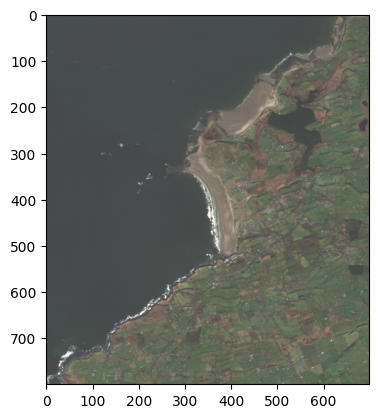

In [128]:
# Find AOI 
rgb = utils.get_rgb(stacked_bands,r=2,contrast=0.4)

x1 = 4900-200
y1 = 5200-200
x2 = 5200+200
y2 = 5600+200

crop_rgb = rgb[y1:y2,x1:x2]
plt.imshow(crop_rgb)

In [129]:
# Get geolocations for AOI
left, top = meta_data.xy(y1,x1)
right, bottom = meta_data.xy(y2,x2)

# Save geolocations
geolocations["rossnowlagh"] = {
    "left": left,
    "top": top,
    "right": right,
    "bottom": bottom
}

print(geolocations["rossnowlagh"])
print(meta_data.index(left, top))
print(meta_data.index(right, bottom))

{'left': 546985.0, 'top': 6050015.0, 'right': 553985.0, 'bottom': 6042015.0}
(5000, 4700)
(5800, 5400)


### Location: Tramore, Co. Waterford, Ireland

In [130]:
# Load the data
file_name = "S2A_MSIL2A_20240105T114451_N0510_R123_T29UPT_20240105T150053"
safe_folder = f"location_examples/{file_name}.SAFE"
safe_directory = os.path.join("../data/raw/", safe_folder)

stacked_bands, meta_data  = utils.stack_10m_bands(safe_directory)
print(stacked_bands.shape)
print(meta_data.profile)

(4, 10980, 10980)
{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 29N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32629"]]'), 'transform': Affine(10.0, 0.0, 600000.0,
       0.0, -10.0, 5800020.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True}


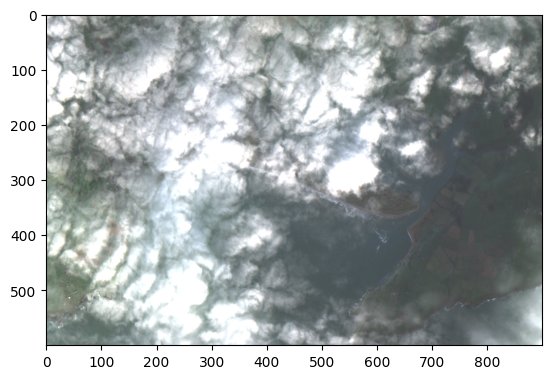

In [131]:
# Find AOI 
rgb = utils.get_rgb(stacked_bands,r=2,contrast=0.4)

x1 = 2600-200
y1 = 1900-200
x2 = 3100+200
y2 = 2100+200

crop_rgb = rgb[y1:y2,x1:x2]
plt.imshow(crop_rgb)

In [132]:
# Get geolocations for AOI
left, top = meta_data.xy(y1,x1)
right, bottom = meta_data.xy(y2,x2)

# Save geolocations
geolocations["tramore"] = {
    "left": left,
    "top": top,
    "right": right,
    "bottom": bottom
}

print(geolocations["tramore"])
print(meta_data.index(left, top))
print(meta_data.index(right, bottom))

{'left': 624005.0, 'top': 5783015.0, 'right': 633005.0, 'bottom': 5777015.0}
(1700, 2400)
(2300, 3300)


In [133]:
# Save geolocations
np.save("../data/processed/meta/geolocations.npy", geolocations)

## Step 2: crop all images to AOI

In [134]:
geolocations = np.load("../data/processed/meta/geolocations.npy", allow_pickle=True).item()
print(geolocations)

{'bull_island': {'left': 685005.0, 'top': 5921495.0, 'right': 695005.0, 'bottom': 5912495.0}, 'portmarnock': {'left': 687005.0, 'top': 5927495.0, 'right': 695005.0, 'bottom': 5917495.0}, 'portrane': {'left': 688505.0, 'top': 5936195.0, 'right': 695005.0, 'bottom': 5928695.0}, 'rossnowlagh': {'left': 546985.0, 'top': 6050015.0, 'right': 553985.0, 'bottom': 6042015.0}, 'tramore': {'left': 624005.0, 'top': 5783015.0, 'right': 633005.0, 'bottom': 5777015.0}}


In [135]:
# Get paths for all sentinel-2 images that contain the AOI

# These are the unique AOI identifiers for the sentinel-2 images
locations = ["bull_island", "portmarnock", "portrane", "rossnowlagh", "tramore"]

# these are the directories that contain relevant sentinel-2 images
sentinel_folders = {"bull_island":["tile_1/2023","tile_1/2019","tile_1/2017"],
                    "portmarnock":["tile_1/2019","tile_1/2017"],
                    "portrane":["tile_1/2024","tile_1/2022","tile_1/2020","tile_1/2019"],
                    "rossnowlagh":["tile_2/2022"],
                    "tramore":["tile_3/2024"]}
filepaths = {}

for location in locations:
    # Get all .SAFE files in the directory
    location_safe_files = []
    for folder in sentinel_folders[location]:
        safe_files = glob.glob(f"../data/raw/{folder}/*.SAFE")
        print(f"{location} | {folder}: {len(safe_files)}")

        base_names = [os.path.basename(f).split(".")[0] for f in safe_files]

        # Get the unique identifiers
        identifiers = [f.split("_")[2] for f in base_names]

        # sort base_names by identifiers in descending order
        sorted_indices = np.argsort(identifiers)[::-1]
        safe_files = np.array(safe_files)[sorted_indices]

        location_safe_files.extend(safe_files)

    filepaths[location] = location_safe_files
    print(f"{location}: {len(location_safe_files)}")
    

bull_island | tile_1/2023: 8
bull_island | tile_1/2019: 12
bull_island | tile_1/2017: 10
bull_island: 30
portmarnock | tile_1/2019: 12
portmarnock | tile_1/2017: 10
portmarnock: 22
portrane | tile_1/2024: 10
portrane | tile_1/2022: 9
portrane | tile_1/2020: 9
portrane | tile_1/2019: 12
portrane: 40
rossnowlagh | tile_2/2022: 19
rossnowlagh: 19
tramore | tile_3/2024: 20
tramore: 20


In [136]:
# Save metadata for all images
processed_files = []

# Iterate through each AOI and its corresponding filepaths
for aoi in locations:

    # Use the same UTM coordinates for all images in the same AOI
    left = geolocations[aoi]["left"]
    top = geolocations[aoi]["top"]
    right = geolocations[aoi]["right"]
    bottom = geolocations[aoi]["bottom"]
    utm = (left, top, right, bottom)

    for path in filepaths[aoi]:

        filename = path.split("/")[-1]

        # Get the year from the filename
        year = path.split("/")[4]

        # Check only images from correct year will be processed
        year_check = filename.split("_")[2][:4]
        assert year == year_check, f"Year mismatch: {year} != {year_check}"

        date = filename.split("_")[2]
        date = date[:4] + "-" + date[4:6] + "-" + date[6:8]

        ID = filename.split("_")[2]
        ID = f"{ID}_{aoi}"
        
        processed_files.append([ID,filename, aoi, left, top, right, bottom, date])

        # Save AOI
        output_tif = f"../data/processed/aoi_crop/{aoi}/{year}/{ID}.tif"
        utils.stack_crop_resample(path, output_tif,
                                       resampling_factor=1, 
                                       utm=utm)

Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/bull_island/2023/20231213T113451_bull_island.tif
Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/bull_island/2023/20231022T114349_bull_island.tif
Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/bull_island/2023/20230904T113321_bull_island.tif
Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/bull_island/2023/20230604T114349_bull_island.tif
Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/bull_island/2023/20230530T114351_bull_island.tif
Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/bull_island/2023/20230420T114351_bull_island.tif
Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/bull_island/2023/20230209T114351_bull_island.tif
Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/bull_island/2023/20230120T114411_bull_island.tif
Saved stacked Sentinel-2 bands to ../data/processed/aoi_crop/bull_island/2019/20191209T113349_bull_island.tif
Saved stac

In [139]:
# Save processed files metadata
processed_files = pd.DataFrame(processed_files, columns=["ID","filename", "aoi", "left", "top", "right", "bottom", "date"])
processed_files.sort_values(by=["aoi","date"], inplace=True, ascending=False)
processed_files.to_csv("../data/processed/meta/processed_files.csv", index=False)

# Step 3: annotate with QGIS
The processed AOI files are now loaded into QGIS and annotated with the help of ariel photography.

# Step 4: combine shape files

In [158]:
shape_file_path = "../data/Vegetation Lines/Vegetation Line Shape Files/*.shp"
shape_files = glob.glob(shape_file_path)
print(shape_files)

all_shape_files = []
for shape_file in shape_files:
    # Read the shapefile
    gdf = gpd.read_file(shape_file)
    
    # Filter out rows where 'line' is NaN
    # These are shape used to help with aligining Sentinel-2 images with ariel photography
    gdf = gdf[gdf.line > 0]

    # Formating for consistency
    gdf.columns = ['ID','LINE','AOI','YEAR','GEOMETRY']
    gdf['AOI'] = gdf['AOI'].str.lower()
    gdf['AOI'] = gdf['AOI'].str.replace(" ", "_")

    # Append to the list
    
    all_shape_files.append(gdf)


# Concatenate all GeoDataFrames into one
all_shape_files = pd.concat(all_shape_files, ignore_index=True)
all_shape_files.reset_index(drop=True, inplace=True)

gdf = gpd.GeoDataFrame(all_shape_files, geometry='GEOMETRY')

# Save combined shapefiles
gdf.to_file("../data/processed/vegetation_lines.shp", driver='ESRI Shapefile')
gdf.head()


['../data/Vegetation Lines/Vegetation Line Shape Files/tramore_2024.shp', '../data/Vegetation Lines/Vegetation Line Shape Files/portmarnock_2019.shp', '../data/Vegetation Lines/Vegetation Line Shape Files/bullisland_2017.shp', '../data/Vegetation Lines/Vegetation Line Shape Files/portrane_2019.shp', '../data/Vegetation Lines/Vegetation Line Shape Files/portrane_2024.shp', '../data/Vegetation Lines/Vegetation Line Shape Files/portrane_2020.shp', '../data/Vegetation Lines/Vegetation Line Shape Files/rossnowlagh_2022.shp', '../data/Vegetation Lines/Vegetation Line Shape Files/portrane_2022.shp', '../data/Vegetation Lines/Vegetation Line Shape Files/bullisland_2023.shp', '../data/Vegetation Lines/Vegetation Line Shape Files/bullisland_2019.shp', '../data/Vegetation Lines/Vegetation Line Shape Files/portmarnock_2017.shp']


ID  LINE      AOI  YEAR  \
0  20240330T114349_tramore   1.0  tramore  2024   
1  20241222T113409_tramore   1.0  tramore  2024   
2  20241127T113421_tramore   1.0  tramore  2024   
3  20241120T114401_tramore   1.0  tramore  2024   
4  20241021T114351_tramore   1.0  tramore  2024   

                                            GEOMETRY  
0  LINESTRING (627373.58 5780386.135, 627383.266 ...  
1  LINESTRING (627373.645 5780381.471, 627383.33 ...  
2  LINESTRING (627374.5 5780375.808, 627384.186 5...  
3  LINESTRING (627370.785 5780375.724, 627380.47 ...  
4  LINESTRING (627373.618 5780383.406, 627383.303...

In [159]:
# Update the processed files metadata with the vegetation lines
gdf_IDs = gdf['ID'].unique()
processed_files['vegetation_line'] = processed_files['ID'].apply(lambda x: x in gdf_IDs)
processed_files.to_csv("../data/processed/meta/processed_files.csv", index=False)

# Sense check

In [160]:
# Load processed files metadata
processed_files = pd.read_csv("../data/processed/meta/processed_files.csv")
processed_files['year'] = processed_files['date'].apply(lambda x: x.split("-")[0])
processed_files.head()

ID                                           filename  \
0  20241222T113409_tramore  S2B_MSIL2A_20241222T113409_N0511_R080_T29UPT_2...   
1  20241127T113421_tramore  S2A_MSIL2A_20241127T113421_N0511_R080_T29UPT_2...   
2  20241120T114401_tramore  S2A_MSIL2A_20241120T114401_N0511_R123_T29UPT_2...   
3  20241021T114351_tramore  S2A_MSIL2A_20241021T114351_N0511_R123_T29UPT_2...   
4  20241011T114351_tramore  S2A_MSIL2A_20241011T114351_N0511_R123_T29UPT_2...   

       aoi      left        top     right     bottom        date  year  \
0  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-12-22  2024   
1  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-11-27  2024   
2  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-11-20  2024   
3  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-10-21  2024   
4  tramore  624005.0  5783015.0  633005.0  5777015.0  2024-10-11  2024   

   vegetation_line  
0             True  
1             True  
2             True  
3             True  
4             True

In [161]:
# Load the combined shapefile
gdf = gpd.read_file("../data/processed/vegetation_lines.shp")
gdf.head()


ID  LINE      AOI  YEAR  \
0  20240330T114349_tramore   1.0  tramore  2024   
1  20241222T113409_tramore   1.0  tramore  2024   
2  20241127T113421_tramore   1.0  tramore  2024   
3  20241120T114401_tramore   1.0  tramore  2024   
4  20241021T114351_tramore   1.0  tramore  2024   

                                            geometry  
0  LINESTRING (627373.58 5780386.135, 627383.266 ...  
1  LINESTRING (627373.645 5780381.471, 627383.33 ...  
2  LINESTRING (627374.5 5780375.808, 627384.186 5...  
3  LINESTRING (627370.785 5780375.724, 627380.47 ...  
4  LINESTRING (627373.618 5780383.406, 627383.303...

In [162]:
# Count the number of images per AOI
locations = ["bull_island", "portmarnock", "portrane", "rossnowlagh", "tramore"]
file_counts = []
for location in locations:

    aoi_files = processed_files[processed_files["aoi"] == location]


    for year in aoi_files['year'].unique():

        # Filter the processed files for the specific AOI and year
        meta_count = aoi_files[aoi_files['year'] == year].shape[0]
        meta_count_true = aoi_files[aoi_files['year'] == year]['vegetation_line'].sum()

        tif_files = glob.glob(f"../data/processed/aoi_crop/{location}/{year}/*.tif")
        tif_count = len(tif_files)

        shape_count = gdf[(gdf['AOI'] == location) & (gdf['YEAR'] == int(year))].shape[0]

        file_counts.append({
            "location": location,
            "year": year,
            "meta": meta_count,
            "tif": tif_count,
            "meta_true": meta_count_true,
            "shape": shape_count
        })

# Convert to DataFrame
file_counts_df = pd.DataFrame(file_counts)

# Result: Numbers for meta and tif must be the same 
# result: meta_true and shape should be the same as well
# Result: number for shape can be lower as we remove some AOI during annotation due to clouds
# Result: Shape number for portrane is 3x as there re 3 vegetation lines in the AOI
file_counts_df

location  year  meta  tif  meta_true  shape
0   bull_island  2023     8    8          8      8
1   bull_island  2019    12   12         11     11
2   bull_island  2017    10   10          8      8
3   portmarnock  2019    12   12         10     10
4   portmarnock  2017    10   10          8      8
5      portrane  2024    10   10         10     30
6      portrane  2022     9    9          9     27
7      portrane  2020     9    9          9     26
8      portrane  2019    12   12         11     33
9   rossnowlagh  2022    19   19         16     16
10      tramore  2024    20   20         15     15

In [144]:
# Result: lengths of line should alwasy be the same
# Result there should be some variation in positions due to geo-referencing correction
for aoi in locations:
    # Get line 1 for each AOI
    aoi_gdf = gdf[(gdf['AOI'] == aoi) & (gdf['LINE'] == 1)]
    for year in aoi_gdf['YEAR'].unique():

        line_lengths = []
        first_points = []
        for geometry in aoi_gdf[aoi_gdf['YEAR'] == year].geometry:
            # Create a mask for the geometry
            line_lengths.append(round(geometry.length))
            first_points.append(geometry.coords[0])

        print(f"\n{aoi} {year} ")

        # Caculate std of the lengths
        std_length = np.round(np.std(line_lengths))
        mean_length = np.round(np.mean(line_lengths))
        print(f"Std length: {std_length} | Mean length: {mean_length}")

        std_points = np.round(np.std(first_points, axis=0))
        mean_points = np.round(np.mean(first_points, axis=0))
        print(f"Std points: {std_points} | Mean points: {mean_points}")


bull_island 2017 
Std length: 0.0 | Mean length: 5407.0
Std points: [0. 2.] | Mean points: [ 688629. 5915255.]

bull_island 2023 
Std length: 0.0 | Mean length: 4438.0
Std points: [1. 5.] | Mean points: [ 688654. 5915231.]

bull_island 2019 
Std length: 0.0 | Mean length: 5365.0
Std points: [1. 2.] | Mean points: [ 688658. 5915234.]

portmarnock 2019 
Std length: 0.0 | Mean length: 4964.0
Std points: [1. 2.] | Mean points: [ 691346. 5920837.]

portmarnock 2017 
Std length: 0.0 | Mean length: 4881.0
Std points: [1. 4.] | Mean points: [ 691347. 5920836.]

portrane 2019 
Std length: 0.0 | Mean length: 1695.0
Std points: [0. 2.] | Mean points: [ 691484. 5932884.]

portrane 2024 
Std length: 0.0 | Mean length: 1701.0
Std points: [1. 3.] | Mean points: [ 691483. 5932887.]

portrane 2020 
Std length: 0.0 | Mean length: 1733.0
Std points: [0. 0.] | Mean points: [ 691483. 5932885.]

portrane 2022 
Std length: 0.0 | Mean length: 1717.0
Std points: [3. 3.] | Mean points: [ 691482. 5932887.]

ros

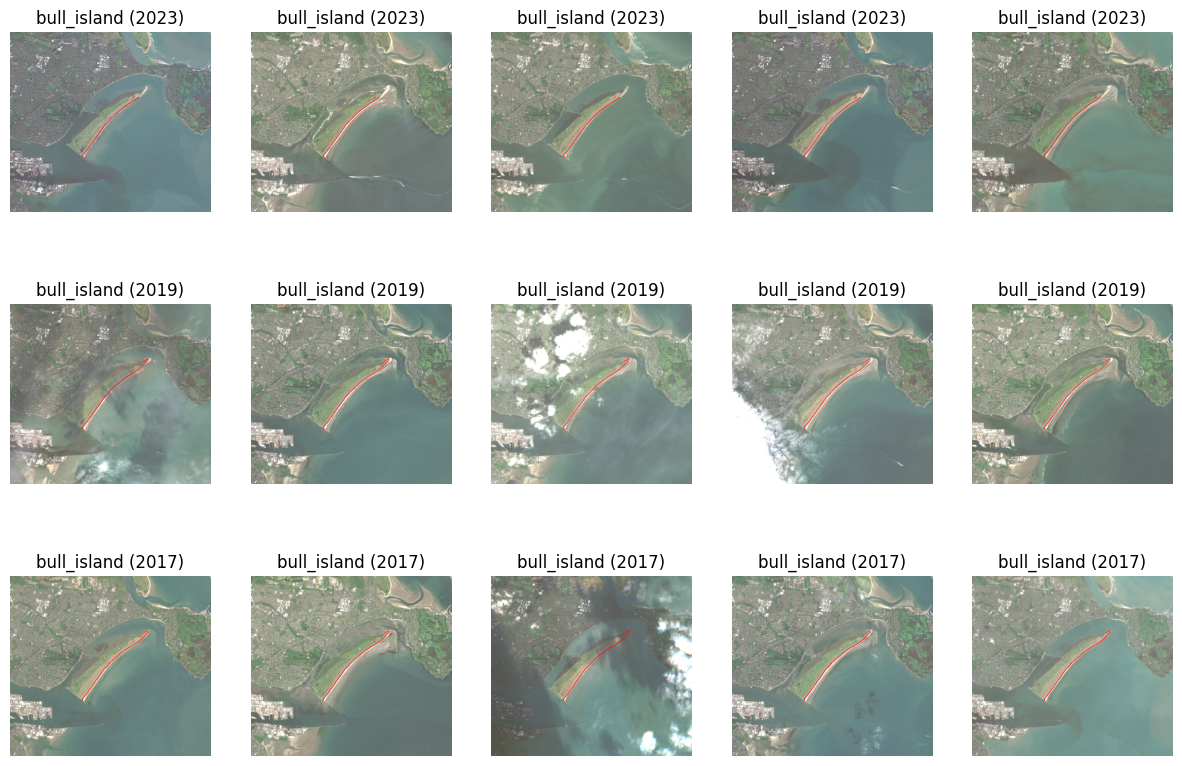

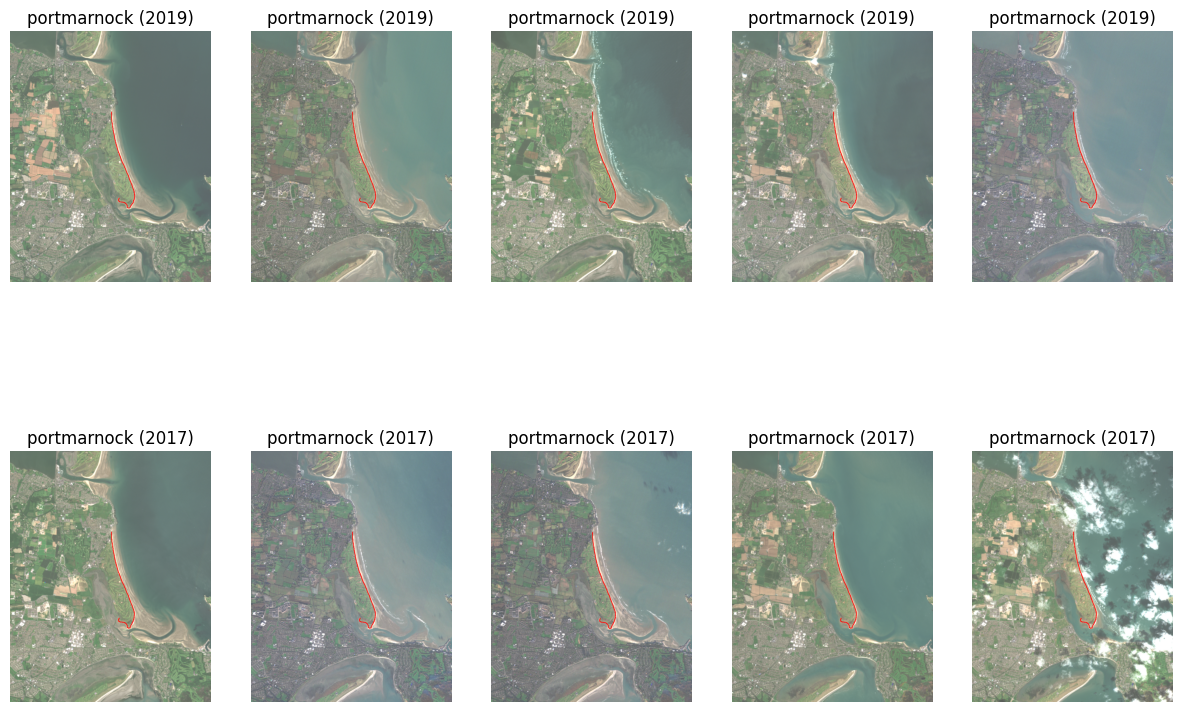

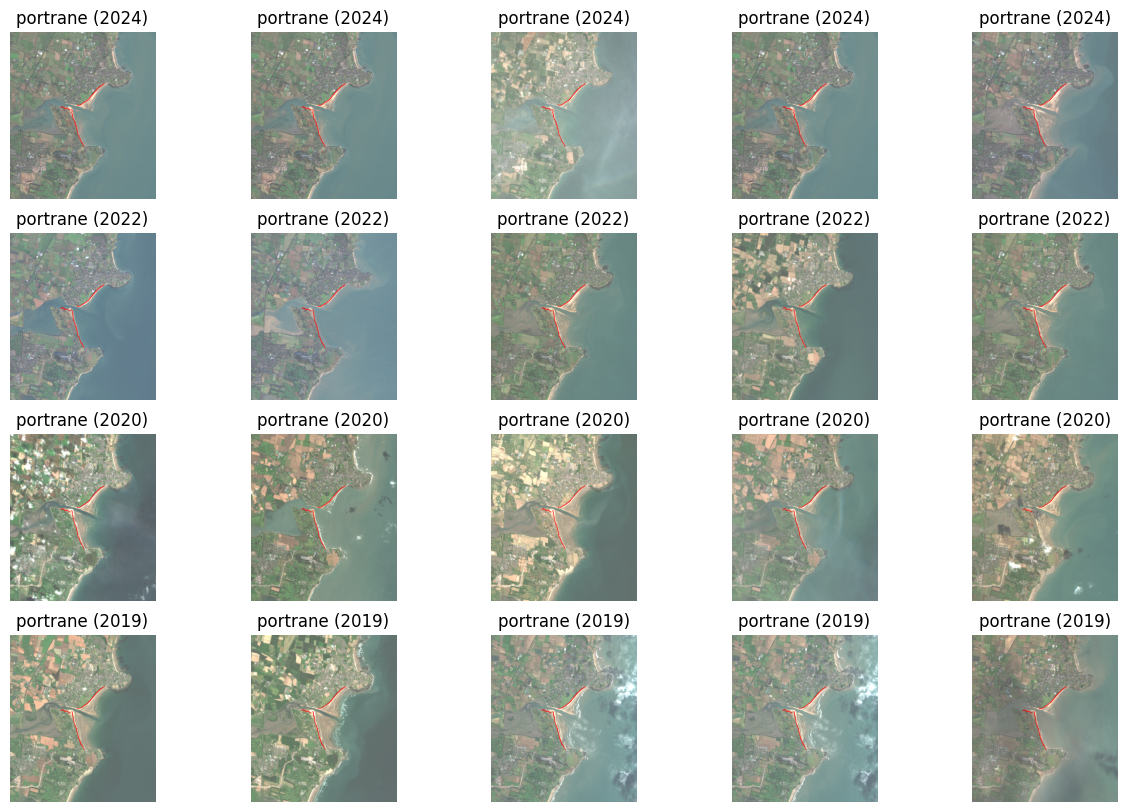

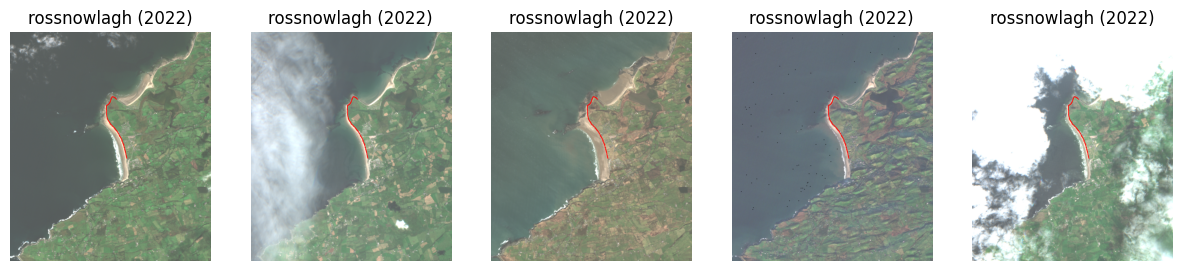

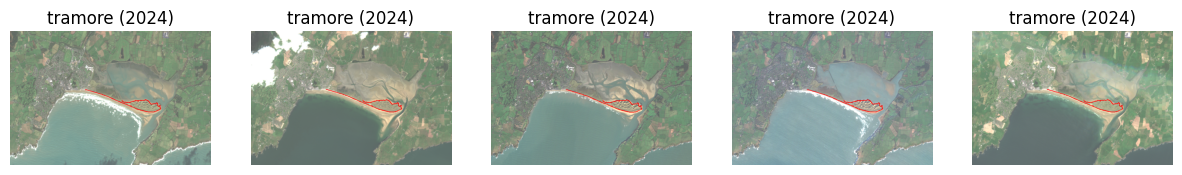

In [145]:
# Check to see if the vegetation lines are correctly aligned with the images
import random 


for aoi in locations:
    aoi_files = processed_files[processed_files['aoi'] == aoi]
    unique_years = aoi_files['year'].unique()

    fig, ax = plt.subplots(len(unique_years),5, figsize=(15, 10))
    
    for i,year in enumerate(unique_years):

        # Select random IDs from vegetation lines shapefile
        gdf_year = gdf[(gdf['AOI'] == aoi) & (gdf['YEAR'] == int(year))]

        IDs = gdf_year['ID'].tolist()
        IDs = random.sample(IDs, 5) 

        for j, ID in enumerate(IDs):

            gdf_ID = gdf_year[gdf_year['ID'] == ID]

            # get RGB image
            file_path = f"../data/processed/aoi_crop/{aoi}/{year}/{ID}.tif"
       

            src = rasterio.open(file_path)
            band1 = src.read(1)
            band2 = src.read(2)
            band3 = src.read(3)

            image = np.dstack((band1, band2, band3))
            rgb_image = utils.get_rgb(image, r=0,g=1,b=2, contrast=0.3)

            # Overlay vegetation lines on the image
            gdf_ID = gdf_year[gdf_year['ID'] == ID]
            
            
            for geometry in gdf_ID.geometry:
                    # Convert geometry to pixel coordinates
                    utm_coords = np.array(geometry.coords)
                    
                    coords = np.array([src.index(x, y) for x, y in utm_coords])
                    coords = coords[:, ::-1]
                    coords = np.round(coords).astype(int)
                    
                    # Draw the polygon on the image
                    cv2.polylines(rgb_image, [coords], isClosed=False, color=(255, 0, 0), thickness=2,)

            try:
                ax[i,j].imshow(rgb_image)
                ax[i,j].set_title(f"{aoi} ({year})")
                ax[i,j].axis('off')
            except:
                ax[j].imshow(rgb_image)
                ax[j].set_title(f"{aoi} ({year})")
                ax[j].axis('off')
    
